# Grokking with a simple model on modular addition in $ \mathbb{Z} / 53 \mathbb{Z} $

## 0. Preliminaries

Imports and set the CUDA device, set the seed

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA       # Needed for PCA of embeddings
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

def set_seed(seed_value=0):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if device == "cuda":
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if device == "mps":
        torch.mps.manual_seed(seed_value)

## 1. Building the dataset
Define the dataset : addition in $ \mathbb{Z} / 53 \mathbb{Z} $ (i.e. addition modulo P=53), with a random split into train and test sets. 

Half of the set is used for training, the rest is used for tests.

In [34]:
# Prime number for modular addition
P = 53

# Create the dataset
set_seed(SEED)
data = []
for i in range(P):
    for j in range(P):
        data.append([i,j,(i+j)%P])
data = np.array(data)

# Split into train and test
TRAIN_FRACTION = 0.5
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
BATCH_SIZE = 64
train_data = torch.tensor(train_data, dtype=torch.long, device=device)
test_data = torch.tensor(test_data, dtype=torch.long, device=device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 2. Model definition
A linear embedding layer followed by concatenation of the two (embedded) tokens, and a simple FF with one hidden layer.

_Our embeddings has 128 dimensions: each integer is encoded with a vector of 128 dimensions_

__First, let's show the NN diagram for clarity__

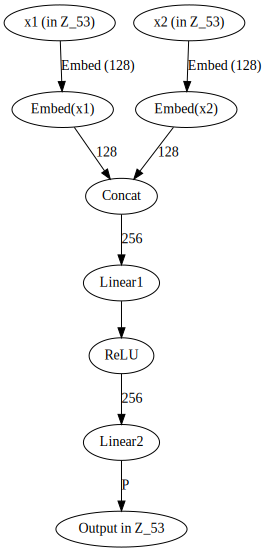

In [35]:
from graphviz import Digraph

def create_network_diagram():
    dot = Digraph()

    # Adding nodes
    dot.node('x1', 'x1 (in Z_53)')
    dot.node('x2', 'x2 (in Z_53)')
    dot.node('E1', 'Embed(x1)')
    dot.node('E2', 'Embed(x2)')
    dot.node('C', 'Concat')
    dot.node('L1', 'Linear1')
    dot.node('R', 'ReLU')
    dot.node('L2', 'Linear2')
    dot.node('O', 'Output in Z_53')

    # Adding edges
    dot.edge('x1', 'E1', label='Embed (128)')
    dot.edge('x2', 'E2', label='Embed (128)')
    dot.edge('E1', 'C', label='128')
    dot.edge('E2', 'C', label='128')
    dot.edge('C', 'L1', label='256')
    dot.edge('L1', 'R')
    dot.edge('R', 'L2', label='256')
    dot.edge('L2', 'O', label='P')

    return dot

create_network_diagram()

__Then let's implement it with pytorch__

In [36]:
D_EMBED = 128
HIDDEN = 256

# Create the NN model
class EmbeddingConcatFFModel(nn.Module):
    def __init__(self):
        super(EmbeddingConcatFFModel, self).__init__()
        self.embed = nn.Embedding(P, D_EMBED)
        self.linear1 = nn.Linear(2 * D_EMBED, HIDDEN)   # 2 * D_EMBED because we concatenate the two embedded tokens
        self.linear2 = nn.Linear(HIDDEN, P)
        self.init_weights()
        
    def forward(self, x1, x2):
        x1 = self.embed(x1)
        x2 = self.embed(x2)
        x = torch.cat((x1, x2), dim=1)  # Concatenate the embedding of the two tokens
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
    # Weight initialization
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)               
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

## 3. Training
We use AdamW with weight decay, and cross entropy loss

In [37]:
NB_EPOCHS = 3000
LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1

set_seed(SEED)
model = EmbeddingConcatFFModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Recording
REPORT_INTERVAL = 250    # How often we print
SAVE_INTERVAL = 50      # How often we save
model_folder = 'intermediary'
# Create folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_loader:
        x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
        optimizer.zero_grad()
        output = model(x1,x2)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for batch in test_loader:
            x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
            output = model(x1,x2)
            loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        
    if epoch % REPORT_INTERVAL == 0:
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")
    
    if epoch % SAVE_INTERVAL == 0:
        # Save model in intermediary folder
        torch.save(model.state_dict(), f"{model_folder}/model_{epoch}.pth")
        
torch.save(model.state_dict(), f"model.pth")

0/3000: Train loss=3.9842, acc=1.4%  /  Test loss=3.9773, acc=1.8%
250/3000: Train loss=0.9200, acc=100.0%  /  Test loss=6.7937, acc=0.0%
500/3000: Train loss=0.2137, acc=100.0%  /  Test loss=5.0488, acc=0.1%
750/3000: Train loss=0.0385, acc=100.0%  /  Test loss=1.9816, acc=44.8%
1000/3000: Train loss=0.0055, acc=100.0%  /  Test loss=0.2564, acc=98.5%
1250/3000: Train loss=0.0007, acc=100.0%  /  Test loss=0.0177, acc=100.0%
1500/3000: Train loss=0.0001, acc=100.0%  /  Test loss=0.0014, acc=100.0%
1750/3000: Train loss=0.0000, acc=100.0%  /  Test loss=0.0002, acc=100.0%
2000/3000: Train loss=0.0000, acc=100.0%  /  Test loss=0.0000, acc=100.0%
2250/3000: Train loss=0.0000, acc=100.0%  /  Test loss=0.0000, acc=100.0%
2500/3000: Train loss=0.0000, acc=100.0%  /  Test loss=0.0000, acc=100.0%
2750/3000: Train loss=0.0000, acc=100.0%  /  Test loss=0.0000, acc=100.0%


## 4. Accuracy evolution, beyond overfitting

Plot the evolution of accuracy and loss during training: 

Observations:
* the accuracy on the training set almost immediately rises to 100%: the model has enough hidden parameters to learn the _training set_ "hy heart" (between epochs 200 and 500)
* most of times, learning "by heart" is considered as [overfitting](https://en.wikipedia.org/wiki/Overfitting)
* Overfitting is often considered as bad, since it makes it more difficult for the model to generalize on previously unencountered situations
* However around epoch #800, the model learns something new: it seems like it "grokked" the modular addition, and the test accuracy quickly raises to 100%

(0.0, 2000.0)

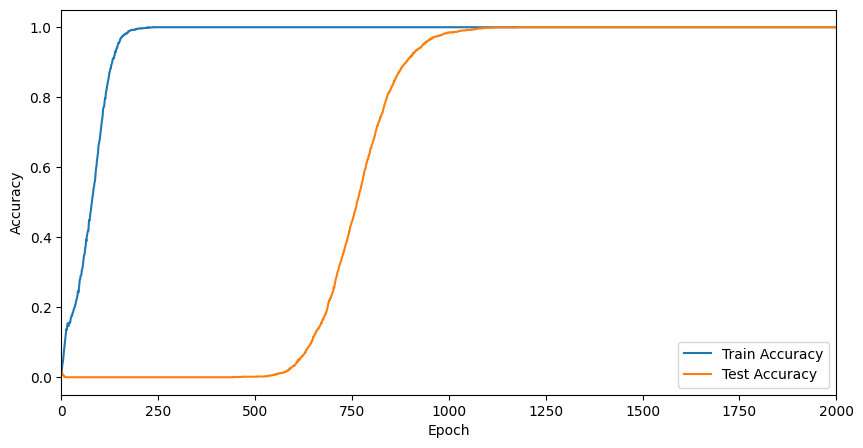

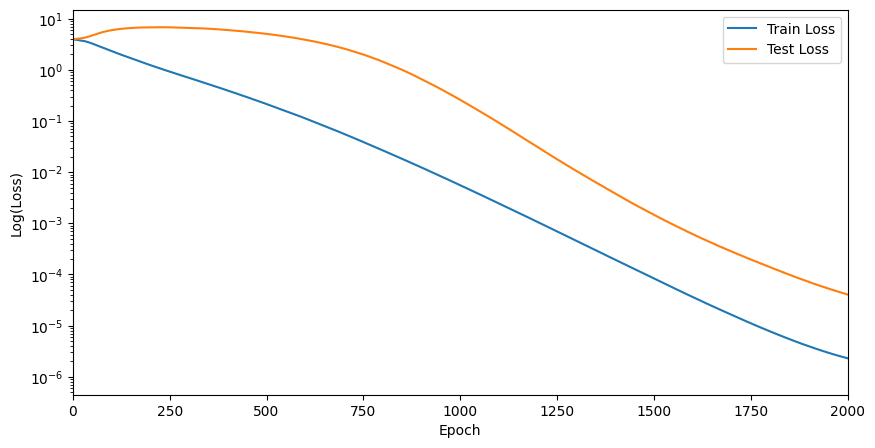

In [38]:
NB_EPOCH_PLOT = 2000

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, NB_EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(0,NB_EPOCH_PLOT)

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, NB_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.yscale('log')
plt.legend()
plt.xlim(0,NB_EPOCH_PLOT)

### Principal Component Analysis of the embeddings

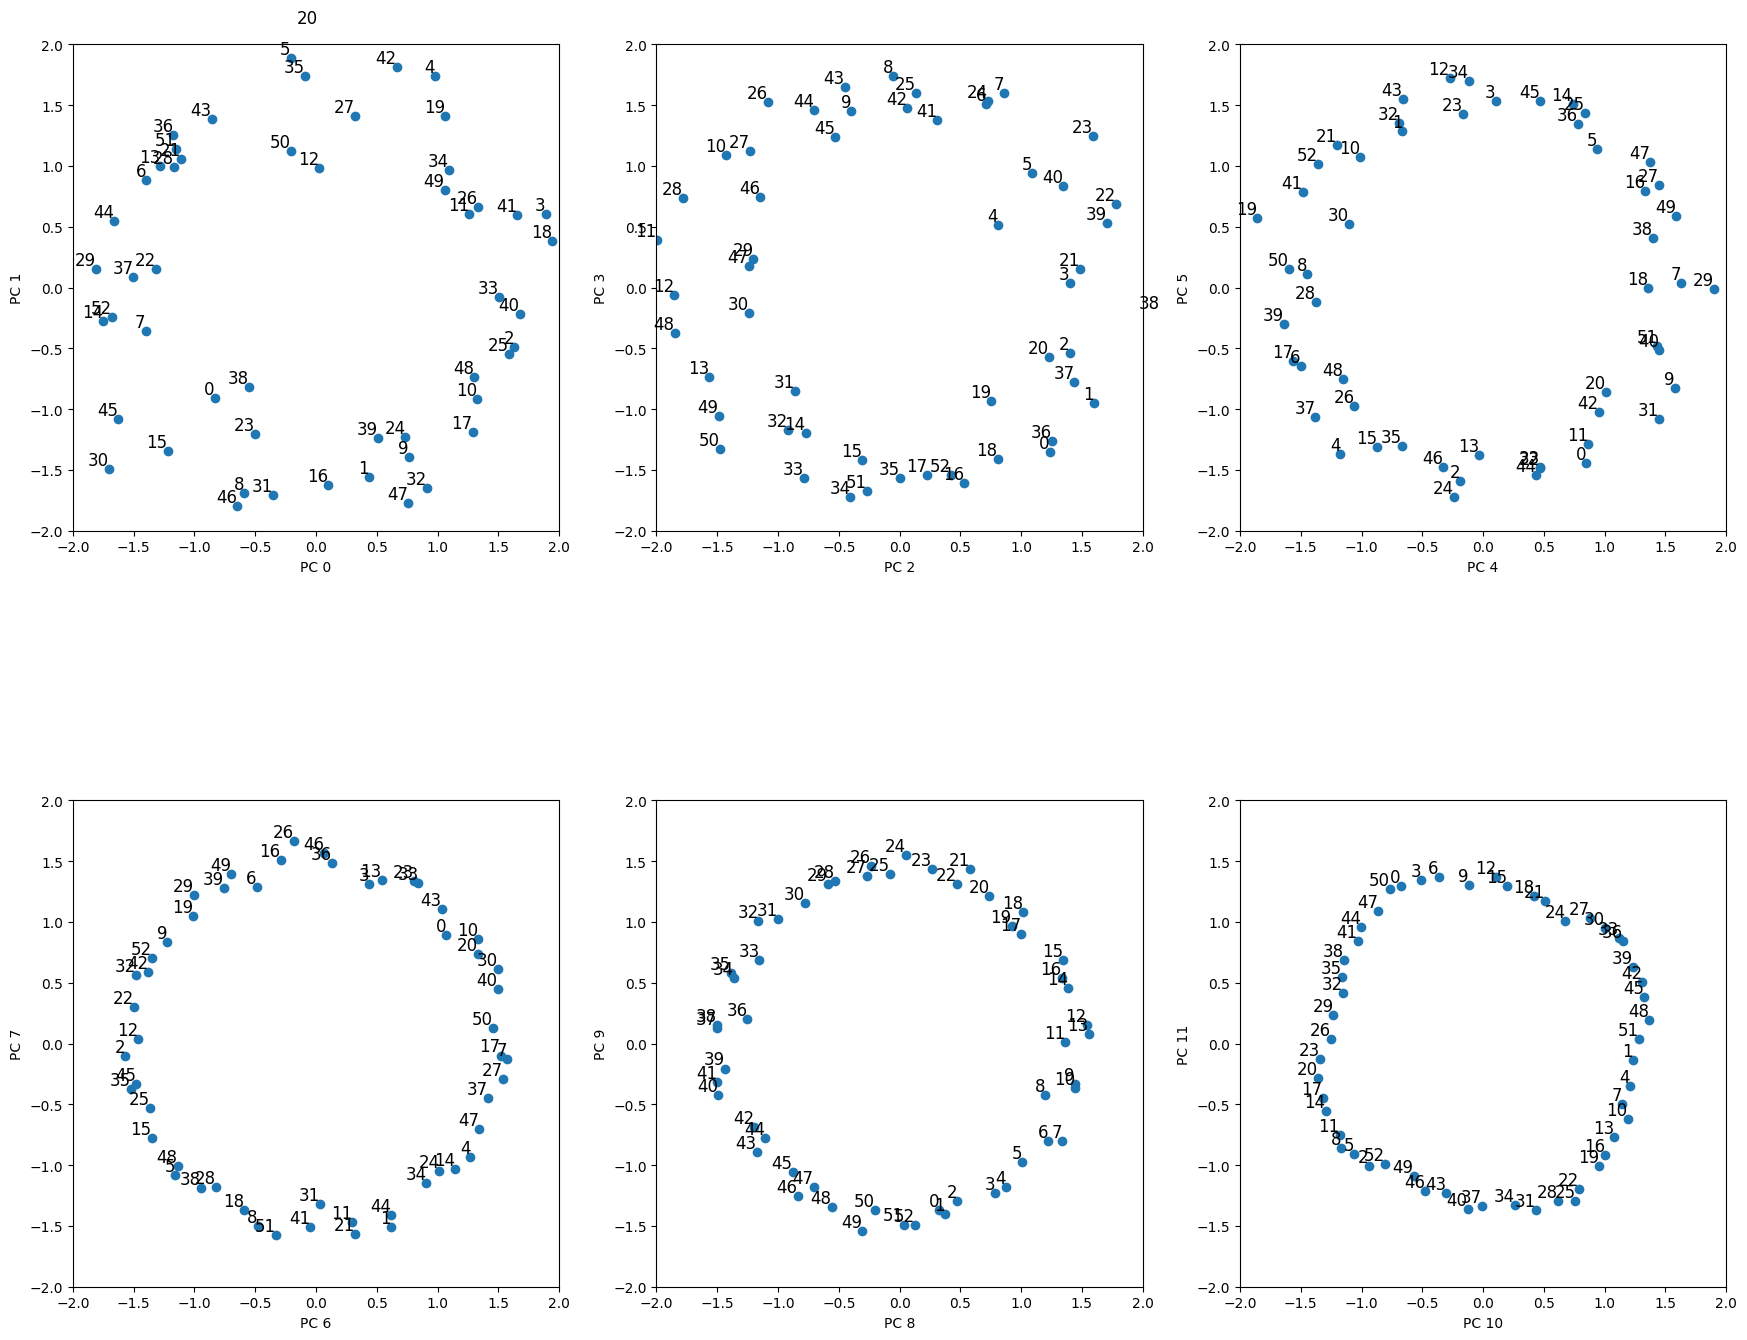

In [39]:
# Extract embeddings
model.load_state_dict(torch.load(f"model.pth"))
model.eval()
with torch.no_grad():
    embeddings = model.embed(torch.arange(0, P).to(device)).cpu().numpy()

# PCA
NB_COMPONENTS = 12
pca = PCA(n_components=NB_COMPONENTS)
embeddings_pca = pca.fit_transform(embeddings)

# Plot
ny = int(np.floor(np.sqrt(16/9 * NB_COMPONENTS // 2)))
nx = int(np.ceil((NB_COMPONENTS //2) / ny))

plt.figure(figsize=(16/9 * 6 * nx, 6 * ny))
for n in range(NB_COMPONENTS // 2):
    plt.subplot(nx, ny, n + 1)
    plt.scatter(embeddings_pca[:, 2 * n + 0], embeddings_pca[:, 2 * n + 1], marker='o')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.gca().set_aspect('equal')

    # Annotate each point on the scatter plot
    for i, (x, y) in enumerate(embeddings_pca[:, (2 * n + 0):(2 * n + 2)]):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        
    plt.xlabel(f"PC {2 * n + 0}")
    plt.ylabel(f"PC {2 * n + 1}")

### Display a movie showing the evolution of the embeddings

Follow the evolution of the embeddings during training projected on the principal components found before

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import Video

# Plot
ny = int(np.floor(np.sqrt(16/9 * NB_COMPONENTS // 2)))
nx = int(np.ceil((NB_COMPONENTS //2) / ny))

fig, axes = plt.subplots(nx, ny, figsize=(16/9 * 6 * nx, 6 * ny))

def create_movie_image(epoch):
    if epoch % 250 == 0:
        print(f"{epoch=}")
    model.load_state_dict(torch.load(f"{model_folder}/model_{epoch}.pth"))
    model.eval()
    with torch.no_grad():
        embeddings = model.embed(torch.arange(0, P).to(device)).cpu().numpy()
    embeddings_pca = pca.transform(embeddings)

    for n, ax in enumerate(axes.flatten()):
        ax.clear()
        ax.scatter(embeddings_pca[:, 2 * n], embeddings_pca[:, 2 * n + 1], marker='o')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')

        for i, (x, y) in enumerate(embeddings_pca[:, (2 * n):(2 * n + 2)]):
            ax.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        
        ax.set_xlabel(f"PC {2 * n}")
        ax.set_ylabel(f"PC {2 * n + 1}")

    plt.suptitle(f"Epoch {epoch}")

# Create animation
ani = FuncAnimation(fig, create_movie_image, frames=range(0, NB_EPOCHS, SAVE_INTERVAL), blit=False)

# Save animation
ani.save('pca_evolution.mp4', writer='ffmpeg')

# close the figure (so that only the movie is shown)
plt.close(fig)

Video("pca_evolution.mp4", width=1000)

epoch=0
epoch=0
epoch=250
epoch=500
epoch=750
epoch=1000
epoch=1250
epoch=1500
epoch=1750
epoch=2000
epoch=2250
epoch=2500
epoch=2750
